<img style="float:left" width="70%" src="../../documentacion/imagenes/escudo_COLOR_1L_DCHA.png">
<img style="float:right" width="10%" src="../../documentacion/imagenes/PythonLogo.svg">
<br style="clear:both;">


<h2 style="display: inline-block; padding: 4mm; padding-left: 2em; background-color: navy; line-height: 1.3em; color: white; border-radius: 10px;">8. Deep Learning LSTM</h2>


 
## Estudiante:

- Jose Luis Perez Gomez

In [37]:
%run 3.Importaciones.ipynb
%run 4.Variables_Clases.ipynb

In [38]:
datosEEG_seg1_standarizado = pd.read_csv('../datos/csv/seg1_stscaler.csv', sep=',')
datosEEG_seg2_standarizado = pd.read_csv('../datos/csv/seg2_stscaler.csv', sep=',')
datosEEG_seg3_standarizado = pd.read_csv('../datos/csv/seg3_stscaler.csv', sep=',')
datosEEG_seg4_standarizado = pd.read_csv('../datos/csv/seg4_stscaler.csv', sep=',')
datosEEG_std_after = pd.read_csv('../datos/csv/all_stscaler_after.csv', sep=',')
datosEEG_std_before = pd.read_csv('../datos/csv/all_stscaler_before.csv', sep=',')


datosEEG_all = [datosEEG_seg1_standarizado, datosEEG_seg2_standarizado, datosEEG_seg3_standarizado, datosEEG_seg4_standarizado, datosEEG_std_after, datosEEG_std_before]
datosEEG_all_nombres = {'segmento_1':datosEEG_seg1_standarizado, 'segmento_2':datosEEG_seg2_standarizado, 'segmento_3':datosEEG_seg3_standarizado,'segmento_4':datosEEG_seg4_standarizado, 'all_std_after':datosEEG_std_after, 'all_std_before':datosEEG_std_before}
nombre_clases = valores_key(datosEEG_seg1_standarizado)

# LSTM (Long short-term memory)

In [39]:
train_datos, val_datos, test_datos = dividir_datos_deep(datosEEG_std_after, 'Key')



In [40]:
print(f'train_datos: {train_datos.shape}')
print(f'val_datos: {val_datos.shape}')
print(f'test_datos: {test_datos.shape}')

train_datos: (542, 11)
val_datos: (108, 11)
test_datos: (28, 11)


In [41]:
train_datos['Key'].value_counts()

Key
0.0    149
1.0    112
4.0    101
2.0     91
3.0     89
Name: count, dtype: int64

In [42]:
val_datos['Key'].value_counts()

Key
0.0    29
1.0    22
4.0    21
2.0    18
3.0    18
Name: count, dtype: int64

In [43]:
test_datos['Key'].value_counts()

Key
0.0    8
1.0    6
2.0    5
4.0    5
3.0    4
Name: count, dtype: int64

In [44]:

def preparar_ventanas(data, target, window_size=10, overlap=5):
    # Validar que el solapamiento sea menor que el tamaño de la ventana
    if window_size <= overlap:
        raise ValueError("Overlap cannot be larger or equal than window size")

    # Obtener las clases únicas de las etiquetas objetivo
    arr_classes = np.unique(target)

    # Listas para almacenar las ventanas de datos y las etiquetas
    X = []
    y = []

    # Iterar sobre cada clase única
    for label in arr_classes:
        # Obtener subconjunto de datos y etiquetas para la clase actual
        subdata = data[target == label].values
        subtarget = target[target == label].values
        
        # Iterar sobre los datos de la clase actual en ventanas
        for i in range(0, len(subdata) - window_size + 1, window_size - overlap):
            # Obtener la ventana de datos de tamaño window_size
            X.append(subdata[i:i + window_size])
            
            # Obtener la etiqueta correspondiente a la última muestra de la ventana
            window_targets = subtarget[i:i + window_size].astype(int)
            y_true = window_targets[-1]
            y.append(y_true)

    # Convertir listas a arrays numpy y retornar
    return np.array(X), np.array(y)





In [45]:
target = 'Key'

columns = train_datos.columns[train_datos.columns != target]


X_train, y_train = preparar_ventanas(train_datos, train_datos[target], WINDOWS_SIZE, OVERLAP )
X_val, y_val = preparar_ventanas(val_datos, val_datos[target], WINDOWS_SIZE, OVERLAP )
X_test, y_test = preparar_ventanas(test_datos, test_datos[target], WINDOWS_SIZE, OVERLAP )




In [46]:
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_val: {X_val.shape}')
print(f'y_val: {y_val.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')


X_train: (532, 3, 11)
y_train: (532,)
X_val: (98, 3, 11)
y_val: (98,)
X_test: (18, 3, 11)
y_test: (18,)


In [47]:
# Definir parámetros
timesteps = X_train.shape[1]
features = X_train.shape[2]
num_classes = len(np.unique(y_train))

model_lstm = Sequential([
    LSTM(units=30, input_shape=(timesteps, features), return_sequences=True),
    Dropout(0.3),
    LSTM(units=30),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

# Learning rate personalizado
learning_rate = 0.0005  # Puedes ajustar este valor

# Definir el optimizador con el learning rate personalizado
optimizer = Adam(learning_rate=learning_rate)


model_lstm.compile(optimizer= optimizer, metrics=['accuracy'], loss='sparse_categorical_crossentropy')



C:\Users\Casa\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [48]:
# Definir callbacks
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
reduce_rl = ReduceLROnPlateau(patience=5)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True)

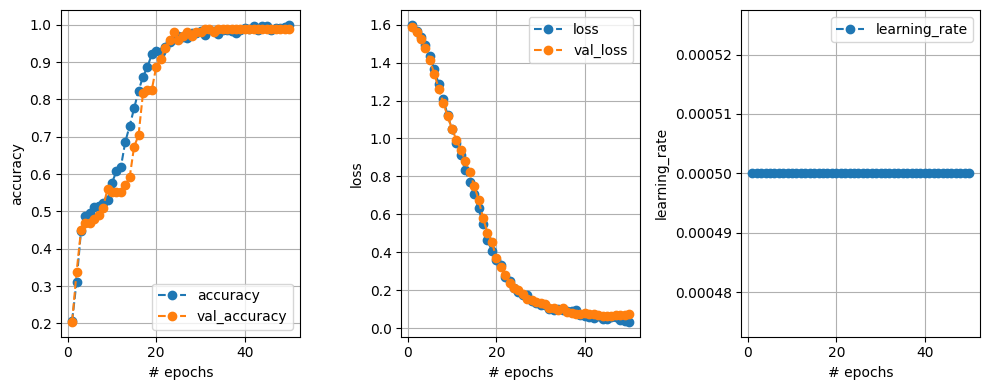

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 1.0000 - loss: 0.0306 - val_accuracy: 0.9898 - val_loss: 0.0728 - learning_rate: 5.0000e-04
1/4 ━━━━━━━━━━━━━━━━━━━━ 1s 426ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002A5AD66AA20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [49]:

# Entrenar el modelo
model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_rl, model_checkpoint, plot_learning])

#model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=50, batch_size=30, validation_data= (X_val, y_val), callbacks=[early_stopping, plot_learning, timer_callback, reduce_rl, model_checkpoint])
#model_lstm_trained = model_lstm.fit(X_train, y_train, epochs=30, batch_size=1, validation_data= (X_val, y_val), callbacks=[plot_learning])

y_pred = model_lstm.predict(X_val)

y_pred_classes = np.argmax(y_pred, axis=1)


accuracy_score_lstm = accuracy_score(y_val, y_pred_classes)
matriz_confusion_lstm = confusion_matrix(y_val, y_pred_classes)

total_simple_lstm_trained = model_lstm_trained



y_pred_test = model_lstm.predict(X_test)

y_pred_classes_test = np.argmax(y_pred_test, axis=1)


accuracy_score_lstm_test = accuracy_score(y_test, y_pred_classes_test)
matriz_confusion_lstm_test = confusion_matrix(y_test, y_pred_classes_test)

total_simple_lstm_trained = model_lstm_trained






,LSTM_Val
Experimento_X,0.989796


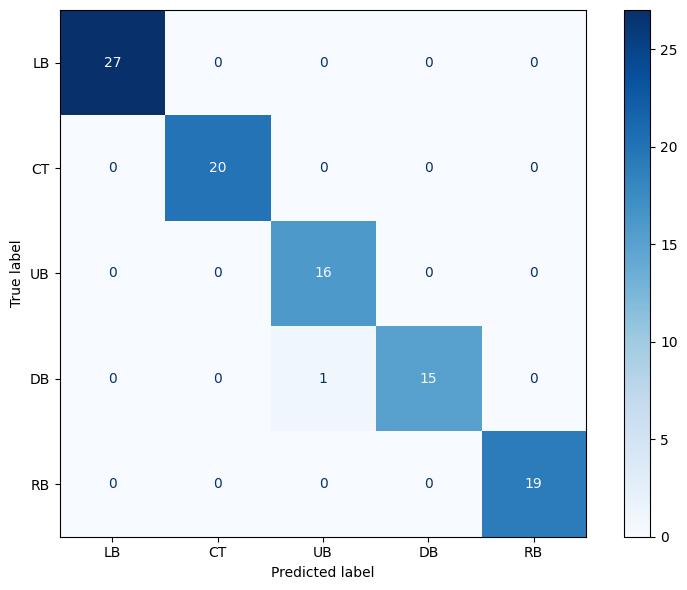

"\ndatos_lstm_test = pd.DataFrame(accuracy_score_lstm_test, columns=['LSTM_Test'], index=['Experimento_X'])\n\ndisplay(datos_lstm_test)\n\n\n# Crea el DataFrame de la matriz de confusión\nmc_lstm = pd.DataFrame(matriz_confusion_lstm_test, index=nombre_clases, columns=nombre_clases)\n\n# Configura la figura\nfig, ax = plt.subplots(figsize=(8, 6))\n\n# Crea la visualización de la matriz de confusión\ndisp = ConfusionMatrixDisplay(confusion_matrix=mc_lstm.values, display_labels=nombre_clases)\ndisp.plot(ax=ax, colorbar=True, cmap='Blues')\n\n# Añade el título (usando el primer título de titulos_all)\n#ax.set_title(titulos_all[0])\n\n# Ajusta el espaciado y muestra la gráfica\nplt.tight_layout()\nplt.show()\n"

In [52]:
datos_lstm = pd.DataFrame(accuracy_score_lstm, columns=['LSTM_Val'], index=['Experimento_X'])

display(datos_lstm)


# Crea el DataFrame de la matriz de confusión
mc_lstm = pd.DataFrame(matriz_confusion_lstm, index=nombre_clases, columns=nombre_clases)

# Configura la figura
fig, ax = plt.subplots(figsize=(8, 6))

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=mc_lstm.values, display_labels=nombre_clases)
disp.plot(ax=ax, colorbar=True, cmap='Blues')

# Añade el título (usando el primer título de titulos_all)
#ax.set_title()

# Ajusta el espaciado y muestra la gráfica
plt.tight_layout()
plt.show()



'''
datos_lstm_test = pd.DataFrame(accuracy_score_lstm_test, columns=['LSTM_Test'], index=['Experimento_X'])

display(datos_lstm_test)


# Crea el DataFrame de la matriz de confusión
mc_lstm = pd.DataFrame(matriz_confusion_lstm_test, index=nombre_clases, columns=nombre_clases)

# Configura la figura
fig, ax = plt.subplots(figsize=(8, 6))

# Crea la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=mc_lstm.values, display_labels=nombre_clases)
disp.plot(ax=ax, colorbar=True, cmap='Blues')

# Añade el título (usando el primer título de titulos_all)
#ax.set_title(titulos_all[0])

# Ajusta el espaciado y muestra la gráfica
plt.tight_layout()
plt.show()
'''


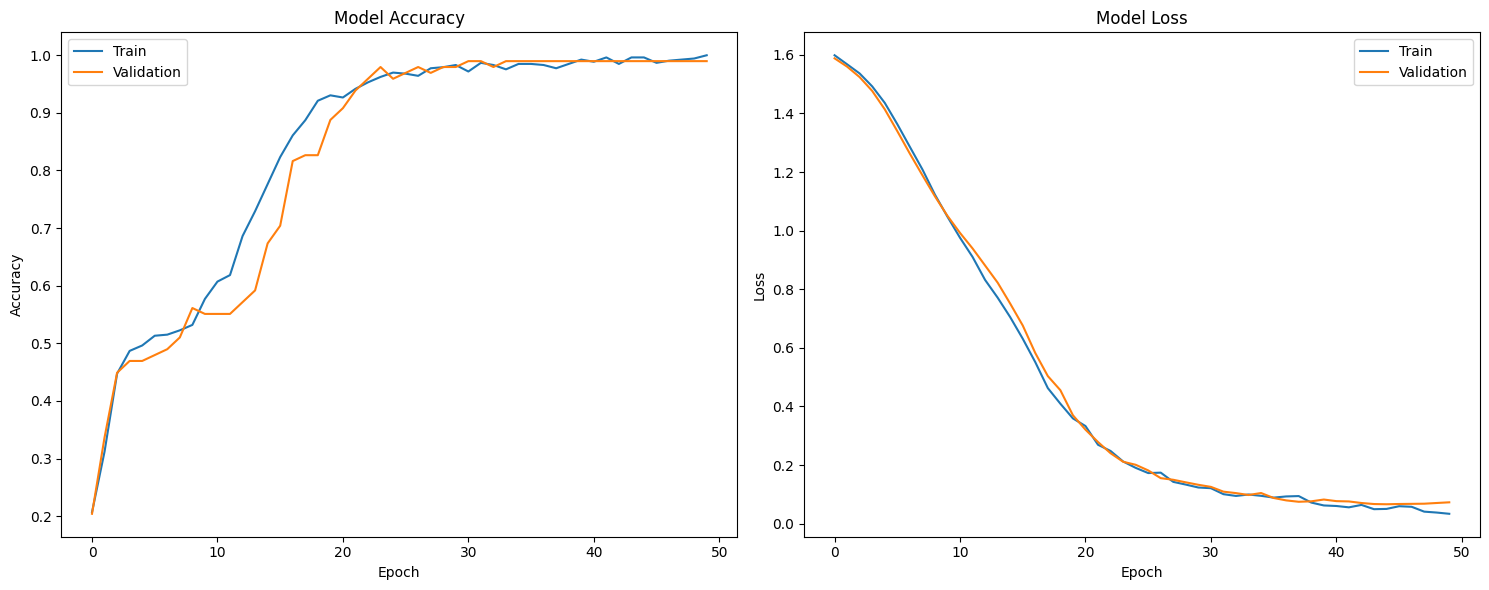

In [53]:

# Función para imprimir la gráfica
def print_chart(ax, titulo_grafica, x_eje, y_eje, datos_lineas, titulos_lineas):
    for linea in datos_lineas:
        ax.plot(linea)
    ax.set_title(titulo_grafica)
    ax.set_xlabel(x_eje)
    ax.set_ylabel(y_eje)
    ax.legend(titulos_lineas, loc='best')

# Crear una figura con dos subgráficos
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Imprimir la gráfica de precisión (accuracy) en el primer subgráfico
print_chart(axes[0], "Model Accuracy", "Epoch", "Accuracy", 
            [model_lstm_trained.history['accuracy'], model_lstm_trained.history['val_accuracy']], ['Train', 'Validation'])

# Imprimir la gráfica de pérdida (loss) en el segundo subgráfico
print_chart(axes[1], "Model Loss", "Epoch", "Loss", 
            [model_lstm_trained.history['loss'], model_lstm_trained.history['val_loss']], ['Train', 'Validation'])

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar las gráficas
plt.show()